<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-их-ресемплирование" data-toc-modified-id="Загрузка-данных-и-их-ресемплирование-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и их ресемплирование</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Отчёт-по-исследованию" data-toc-modified-id="Отчёт-по-исследованию-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Отчёт по исследованию</a></span></li></ul></div>

# Проект: модель для прогнозирования количества заказов такси

Описание задачи: Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания, значение метрики RMSE на тестовой выборке должно быть не больше 48

## Загрузка данных и их ресемплирование

Загрузим необходимые библиотеки

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install CatBoost

Note: you may need to restart the kernel to use updated packages.


In [3]:
# для Jupyter Notebook:
! pip install matplotlib==3.7.1 -q
! pip install -U scikit-learn -q

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sklearn
import sklearn.metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, \
                                                              GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt

In [5]:
TEST_SIZE = 0.1
RANDOM_STATE = 1897

In [6]:
# загрузка файла данных из GD:
#! gdown 1GNuYB4WMAxKBzlzqI-ockCAsVWVB_wv- -q

In [7]:
#data = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])

In [8]:
# для Jupyter Notebook:

path_1 = 'taxi.csv'
path_2 = '/datasets/taxi.csv'

if os.path.exists(path_1):
    data = pd.read_csv(path_1, index_col=[0], parse_dates=[0])
elif os.path.exists(path_2):
    data = pd.read_csv(path_2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong!')

In [9]:
# настройка для вывода всех столбцов в датасете:
pd.set_option('display.max_columns', None)

In [10]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Датасет содержит всего два признака:

- `datetime` - информация о дате и времени совершения заказов такси
- `num_orders` - количество заказов такси

In [12]:
# проверим, расположены ли дата и время в хронологическом порядке:
display(data.index.is_monotonic_increasing)

True

In [13]:
# проверим датасет на пропущенные значения:
data.isna().sum()

num_orders    0
dtype: int64

In [14]:
# проверим датасет на явные дубликаты:
data.index.duplicated().sum()

0

In [15]:
# ресемплируем данные по одному часу:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [16]:
# проверим датасет после ресемплирования:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


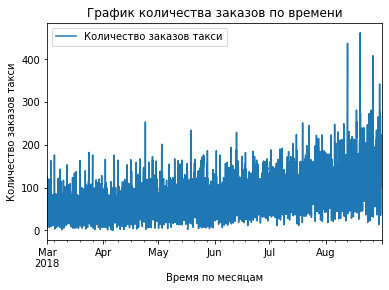

In [17]:
# построим график временного ряда:
data.plot(legend=True)
plt.xlabel("Время по месяцам")
plt.ylabel("Количество заказов такси")
plt.title("График количества заказов по времени") 
plt.legend(["Количество заказов такси"])
plt.show()

Видим, что количество заказов начинает расти с мая. К сожалению, отсутствуют данные с сентября по март, поэтому о каких-то тенденциях в этом интервале сказать затруднительно.

Выводы по разделу:

- загрузили данные, поменяли тип в столбце `datetime` на корректный;
- проверили данные на пропущенные значения и явные дубликаты - и те, и те отсутствуют;
- ресемплировали данные по одному часу. Виден рост количества заказов такси, начиная с мая.

## Анализ данных

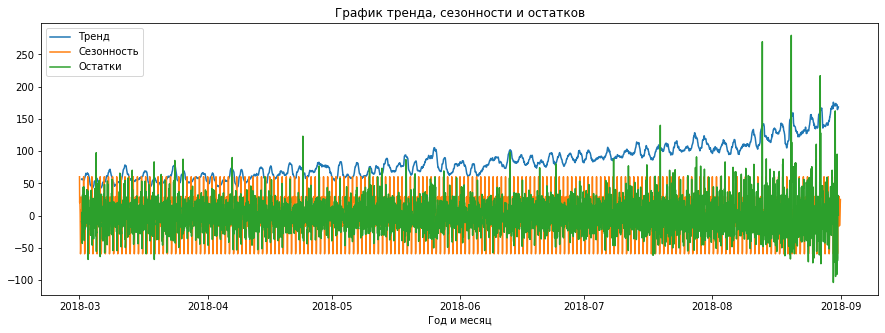

In [18]:
# сделаем декомпозицию (разложим временной ряд на три составляющие):
decomposed = seasonal_decompose(data)

# сохраним результаты декомпозиции в переменные:
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# построим график, на который выведем результаты ресемплирования и декомпозиции:
plt.figure(figsize=(15, 5))
plt.plot(trend, label='Тренд')
plt.plot(seasonal, label='Сезонность')
plt.plot(residual, label='Остатки')
plt.legend()
plt.xlabel("Год и месяц")
plt.title("График тренда, сезонности и остатков")
plt.show()

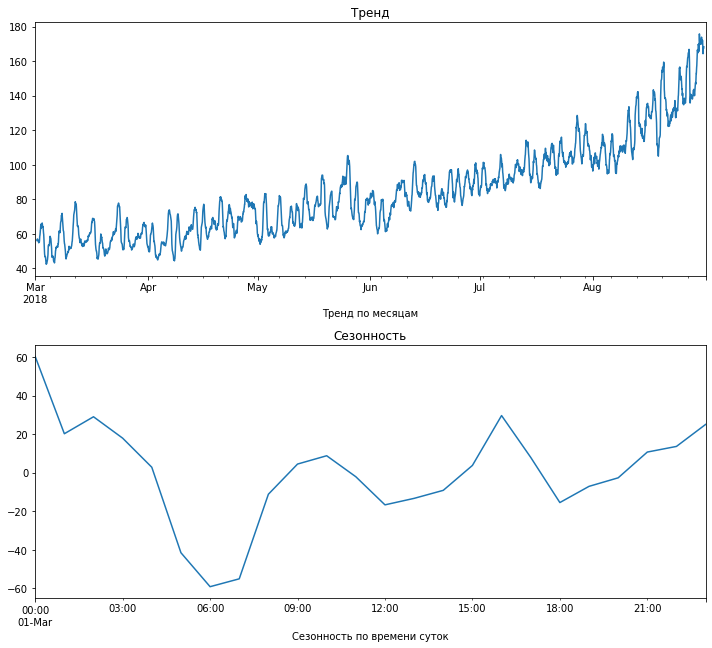

In [19]:
# построим графики, на которых отдельно выведем тренд и сезонность по дням:
plt.figure(figsize=(10, 13))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel("Тренд по месяцам")
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Сезонность по времени суток")
plt.tight_layout()

Тренд выглядит более плавным и соответствует общей закономерности в повышении количества заказов такси, начиная с мая (что может объясняться стартом периода отпусков, а также развитием бизнеса). Что касается количества заказов в зависимости от времени суток, то наиболее популярные часы - от 00:00 до 03:00, в 16:00 и после 21:00, что можно объяснить популярным временем прилёта самолётов или отсутствием общественного транспорта ночью. И, наоборот, в 6 утра количество заказов минимально.

In [20]:
# посмотрим на статистические данные признака:
data.describe().round(2)

,num_orders
count,4416.00
mean,84.42
std,45.02
min,0.00
25%,54.00
50%,78.00
75%,107.00
max,462.00


In [21]:
# функция для вычисления процента выбросов:
def outliers(dataset, column):
    q1 = dataset[column].quantile(0.25)
    q3 = dataset[column].quantile(0.75)
    iqr = q3 - q1
    quant1 = q1 - 1.5*iqr
    quant3 = q3 + 1.5*iqr
    total = dataset.shape[0]
    emission = dataset[(dataset[column] < quant1) | \
     (dataset[column] > quant3)].shape[0]

    emission_quant = (emission / total) * 100
    return np.round((emission_quant), decimals=2)

In [22]:
outliers(data, 'num_orders')

2.74

Количество выбросов незначительно, посмотрим на них далее чуть подробнее:

In [23]:
# гистограмма распределения количественного признака
def histogram(dataset, column):
    dataset[column].plot(kind='hist', bins=20, grid=True, \
                figsize=(5, 5), title=(f'Распределение признака "{column}"'))
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.show()
    return None

# диаграмма размаха
def whiskers(dataset, column):
    dataset.boxplot(column, figsize=(5, 5))
    plt.title(f'Диаграмма размаха признака "{column}"')
    plt.ylabel('Количество')
    plt.show()
    print(dataset[column].describe().round(2))
    return None

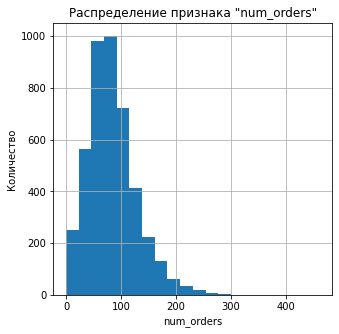

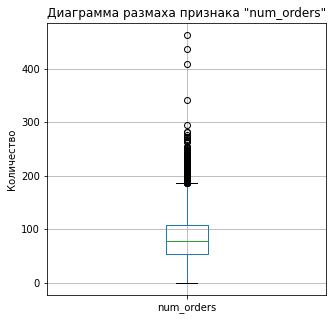

count    4416.00
mean       84.42
std        45.02
min         0.00
25%        54.00
50%        78.00
75%       107.00
max       462.00
Name: num_orders, dtype: float64


In [24]:
histogram(data, 'num_orders')
whiskers(data, 'num_orders')

Распределение признака нормальное, удалять выбросы не будем.

Выводы по разделу:

- разложили временной ряд на тренд, сезонную компоненту и остатки. Тренд выглядит более плавным и соответствует общей закономерности в повышении количества заказов такси, начиная с мая (что может объясняться стартом периода отпусков, а также развитием бизнеса). Что касается количества заказов в зависимости от времени суток, то наиболее популярные часы - от 00:00 до 03:00, в 16:00 и после 21:00, что можно объяснить популярным временем прилёта самолётов или отсутствием общественного транспорта ночью. В 6 утра количество заказов минимально;
- вычислили значение выбросов (незначительное, удалять не стали), построили гистограмму распределения (распределение нормальное) и диаграмму размаха.

## Обучение моделей

Создадим новые признаки в датасете, для этого напишем функцию:

In [25]:
# функция для создания признаков:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift() \
                                .rolling(rolling_mean_size).mean()

In [26]:
# создадим признаки:
make_features(data, 20, 10)

In [27]:
data.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# разделим выборки на тренировочную и тестовую:
train, test = train_test_split(data, shuffle=False, test_size=TEST_SIZE, \
                               random_state=RANDOM_STATE)
# удалим пропуски:
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

# кодируем признаки для линейной модели:
ohe = OneHotEncoder(sparse_output=False, drop='first')
encoded_train = ohe.fit_transform(features_train[['dayofweek', 'hour']])
encoded_test = ohe.transform(features_test[['dayofweek', 'hour']])

# создаём датасет для закодированных признаков
ohe_columns = ohe.get_feature_names_out(['dayofweek', 'hour'])
encoded_train_df = pd.DataFrame(encoded_train, columns=ohe_columns, \
                                index=features_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=ohe_columns, \
                               index=features_test.index)

# добавляем закодированные признаки обратно в features_train_scaled
features_train_scaled = pd.concat([features_train.drop(['dayofweek', 'hour'], \
                                          axis=1), encoded_train_df], axis=1)
features_test_scaled = pd.concat([features_test.drop(['dayofweek', 'hour'], \
                                          axis=1), encoded_test_df], axis=1)

In [29]:
# проверим размеры выборок:
display(features_train.shape, target_train.shape)
display(features_test.shape, target_test.shape)

(3954, 24)

(3954,)

(442, 24)

(442,)

In [30]:
# используем метод кросс-валидации TimeSeriesSplit, т.к. он адаптированн
# специально для временных рядов. Он гарантирует, что порядок временного ряда
# сохраняется, и данные в будущем не "заглядывают" в прошлые данные:
tsscv = TimeSeriesSplit(n_splits=5)

In [31]:
# создадим функцию для перебора моделей:
def model_grid_search(model, params, features_train, \
                      target_train, tsscv, scoring, verbose=1):
    grid = GridSearchCV(
        model,
        param_grid=params,
        cv=tsscv,
        scoring=scoring,
        n_jobs=-1,
        verbose=verbose
    )
    grid.fit(features_train, target_train)

    # извлекаем лучшие результаты:
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_score = grid.best_score_ * -1

    print(f'Лучший результат RMSE модели: {best_score:.4f}')
    print(f'Лучшие параметры модели: {best_params}')

    return best_model, best_params, best_score

In [32]:
# обучим модель линейной регнессии:
model_lr = LinearRegression()
params_lr = {'fit_intercept': [True, False], 'copy_X': [True, False]}

best_model_linear, best_params_linear, best_result_linear = model_grid_search(
    model=model_lr,
    params=params_lr,
    features_train=features_train_scaled,
    target_train=target_train,
    tsscv=tsscv,
    scoring='neg_root_mean_squared_error'
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучший результат RMSE модели: 25.7069
Лучшие параметры модели: {'copy_X': True, 'fit_intercept': True}


In [33]:
# обучим модель дерева решений:
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
params_tree = {
    'max_depth': range(2, 5),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(2, 5)
}

best_model_tree, best_params_tree, best_result_tree = model_grid_search(
    model=model_tree,
    params=params_tree,
    features_train=features_train,
    target_train=target_train,
    tsscv=tsscv,
    scoring='neg_root_mean_squared_error'
)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучший результат RMSE модели: 31.7961
Лучшие параметры модели: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [34]:
# обучим модель LightGBM:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
params_lgbm = {
    'num_leaves': range(2, 5),
    'max_depth': range(2, 5),
    'learning_rate': [0.01, 0.1, 0.2]
}

best_model_lgbm, best_params_lgbm, best_result_lgbm = model_grid_search(
    model=model_lgbm,
    params=params_lgbm,
    features_train=features_train,
    target_train=target_train,
    tsscv=tsscv,
    scoring='neg_root_mean_squared_error'
)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучший результат RMSE модели: 25.6627
Лучшие параметры модели: {'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 4}


In [35]:
# обучим модель CatBoost:
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)
params_catboost = {
    'iterations': range(2, 5),
    'depth': range(2, 5),
    'learning_rate': [0.01, 0.1, 0.2]
}

best_model_catboost, best_params_catboost, best_result_catboost = \
  model_grid_search(
    model=model_catboost,
    params=params_catboost,
    features_train=features_train,
    target_train=target_train,
    tsscv=tsscv,
    scoring='neg_root_mean_squared_error'
)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучший результат RMSE модели: 34.5812
Лучшие параметры модели: {'depth': 4, 'iterations': 4, 'learning_rate': 0.2}


In [36]:
# сводная таблица по всем моделям:
rmse_pivot = pd.DataFrame()

In [37]:
rmse_pivot.loc['LinearRegression', 'RMSE'] = best_result_linear
rmse_pivot.loc['DecisionTree', 'RMSE'] = best_result_tree
rmse_pivot.loc['LightGBM', 'RMSE'] = best_result_lgbm
rmse_pivot.loc['CatBoost', 'RMSE'] = best_result_catboost
rmse_pivot

,RMSE
LinearRegression,25.706899
DecisionTree,31.796098
LightGBM,25.662713
CatBoost,34.581217


Победила модель LightGBM, её и будем использовать для проверки на тестовых данных:

In [38]:
pred_test = best_model_lgbm.predict(features_test)

print(f'RMSE на тестовой выборке:' \
      f'{round(sqrt(mean_squared_error(target_test, pred_test)), 2)}')

RMSE на тестовой выборке:45.14


Выводы по разделу:

- написали функцию для создания новых признаков в датасете: `month`, `day`, `dayofweek`, `hour`;
- разделили выборки на тренировочную и тестовую, создали функцию для перебора моделей и обучили 4 модели: `LinearRegression`, `DecisionTree`, `LightGBM`, `Catboost`;
- в результате обучения на тренировочных данных лучшей по метрике `RMSE` себя показала модель `LightGBM`, взяли её для проверки на тестовых данных;
- получили значение `RMSE` на тестовых данных, равное 45.14, что удовлетворяет условиям задачи (<=48).

## Отчёт по исследованию

Для решения задачи предсказания количества такси на следующий час, были проделаны следующие этапы исследования:

- загрузка данных и их ресемплирование:
  - загрузили данные, поменяли тип в столбце `datetime` на корректный;
  - проверили данные на пропущенные значения и явные дубликаты - и те, и те отсутствуют;
  - ресемплировали данные по одному часу. Виден рост количества заказов такси, начиная с мая;

- анализ данных:
  - разложили временной ряд на тренд, сезонную компоненту и остатки. разложили временной ряд на тренд, сезонную компоненту и остатки. Тренд выглядит более плавным и соответствует общей закономерности в повышении количества заказов такси, начиная с мая (что может объясняться стартом периода отпусков, а также развитием бизнеса). Что касается количества заказов в зависимости от времени суток, то наиболее популярные часы - от 00:00 до 03:00, в 16:00 и после 21:00, что можно объяснить популярным временем прилёта самолётов или отсутствием общественного транспорта ночью. В 6 утра количество заказов минимально;
  - вычислили значение выбросов (незначительное, удалять не стали), построили гистограмму распределения (распределение нормальное) и диаграмму размаха;

- обучение моделей и проверка на тестовых данных:
  - написали функцию для создания новых признаков в датасете: `month`, `day`, `dayofweek`, `hour`;
  - разделили выборки на тренировочную и тестовую, создали функцию для перебора моделей и обучили 4 модели: `LinearRegression`, `DecisionTree`, `LightGBM`, `Catboost`;
  - в результате обучения на тренировочных данных лучшей по метрике `RMSE` себя показала модель `LightGBM` (RMSE = 25.66), взяли её для проверки на тестовых данных;
  - получили значение `RMSE` на тестовых данных, равное 45.14, что удовлетворяет условиям задачи (<=48).